# Markov State Model Construction

[Exposition goes here....]


First, let's convert the kinetic Monte Carlo trajectories into discrete-time versions amenable to MSM analysis

In [1]:
import numpy as np
import glob

from IsingTrajectory import *

# convert a kinetic MC trajectories to discrete-time trajs for MSM analysis
filenames = glob.glob('*_10M_*17.0*.traj.npy')
names = [f.replace('.traj.npy','') for f in filenames]

for name in names:
    t = IsingTrajectory()
    t.load(name)
    t.discretize(name)



Read n0_10M_deps17.0.stats.dat
Read n0_10M_deps17.0.traj.npy
Wrote: n0_10M_deps17.0.msmtraj.npy
Read n10_10M_deps17.0.stats.dat
Read n10_10M_deps17.0.traj.npy
Wrote: n10_10M_deps17.0.msmtraj.npy
Read n11_10M_deps17.0.stats.dat
Read n11_10M_deps17.0.traj.npy
Wrote: n11_10M_deps17.0.msmtraj.npy
Read n12_10M_deps17.0.stats.dat
Read n12_10M_deps17.0.traj.npy
Wrote: n12_10M_deps17.0.msmtraj.npy
Read n13_10M_deps17.0.stats.dat
Read n13_10M_deps17.0.traj.npy
Wrote: n13_10M_deps17.0.msmtraj.npy
Read n14_10M_deps17.0.stats.dat
Read n14_10M_deps17.0.traj.npy
Wrote: n14_10M_deps17.0.msmtraj.npy
Read n15_10M_deps17.0.stats.dat
Read n15_10M_deps17.0.traj.npy
Wrote: n15_10M_deps17.0.msmtraj.npy
Read n1_10M_deps17.0.stats.dat
Read n1_10M_deps17.0.traj.npy
Wrote: n1_10M_deps17.0.msmtraj.npy
Read n2_10M_deps17.0.stats.dat
Read n2_10M_deps17.0.traj.npy
Wrote: n2_10M_deps17.0.msmtraj.npy
Read n3_10M_deps17.0.stats.dat
Read n3_10M_deps17.0.traj.npy
Wrote: n3_10M_deps17.0.msmtraj.npy
Read n4_10M_deps17.0.s

## time-lagged Indepedent Component Analysis (tICA)

Next, the tICA algorithm is used perform dimensionality reduction to a subspace of tICs representing the degrees fo freedom along which the most time-correlated (i.e. slowest) motions occur. 

In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from msmbuilder.decomposition import tICA, PCA

filenames = glob.glob('*_10M_*17.0*.msmtraj.npy')  # s5_10M_deps17.0.msmtraj.npy
nfiles = len(filenames)
trajs = [np.load(filenames[trial]) for trial in range(nfiles)]

ntica = 4
tica = tICA(n_components=ntica, lag_time=1)
tica_coords = tica.fit_transform(trajs)
#print 'tica_coords', tica_coords


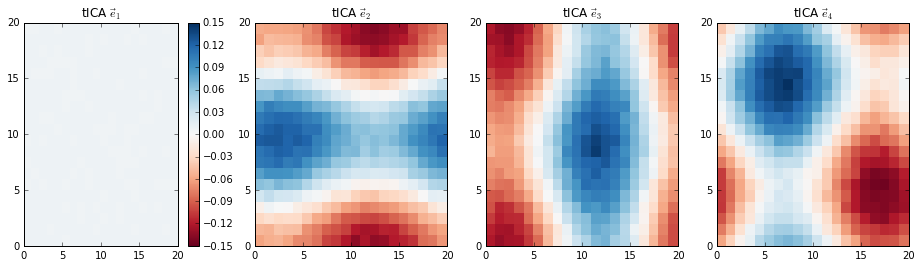

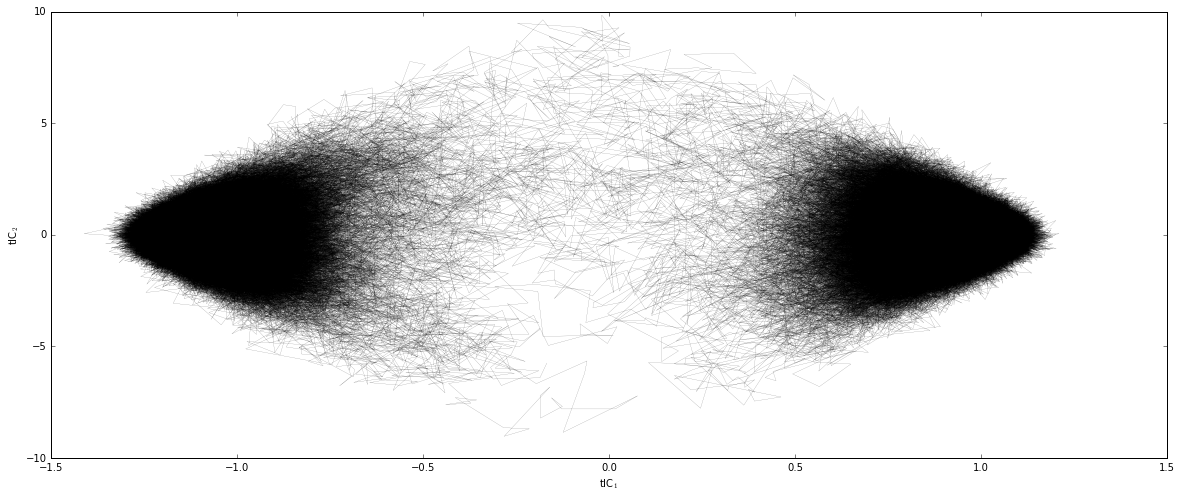

In [3]:
plt.figure( figsize=(20,4))

for j in range(ntica):
    plt.subplot(1,5,j+1)
    #print 'tica.eigenvectors_[:,j].min()', tica.eigenvectors_[:,j].min()
    #print 'tica.eigenvectors_[:,j].max()', tica.eigenvectors_[:,j].max()
    plt.pcolor( tica.eigenvectors_[:,j].reshape( (20,20) ), cmap='RdBu', vmin=-0.15, vmax=0.15)
    if j == 0:
        plt.colorbar()
    plt.title('tICA $\\vec{e}_%d$'%(j+1))

plt.figure( figsize=(20,8))
for i in range(len(tica_coords)):
#for i in range(2):
    plt.plot(tica_coords[i][:,0],tica_coords[i][:,1],'k-', linewidth=0.1)
    plt.xlabel('tIC$_1$')
    plt.ylabel('tIC$_2$')


## Clustering and visualization
See: http://msmbuilder.org/3.7.0/examples/Fs-Peptide-in-RAM.html

(20622, 4)
(20622,)


/Users/vv/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


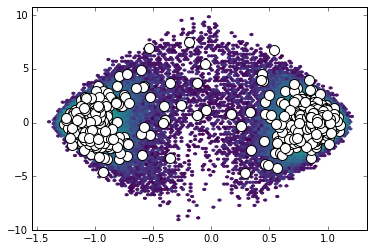

In [4]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=1000, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_coords)
#print(cluster.summarize())

print(tica_coords[0].shape)
print(clustered_trajs[0].shape)

txx = np.concatenate(tica_coords)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

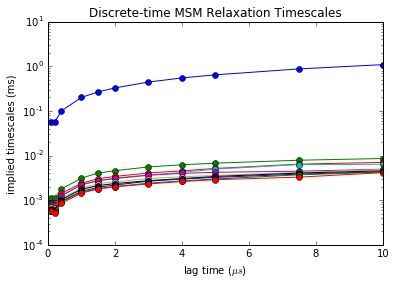

In [6]:
from msmbuilder.msm import ContinuousTimeMSM, MarkovStateModel, implied_timescales

lag_times = np.array([1, 2, 4, 10, 15, 20, 30, 40, 50, 75, 100])
n_timescales = 10
dt = 1.0e-7

msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False))
for i in range(n_timescales):
   plt.plot(lag_times*dt*1.0e6, msm_timescales[:, i]*dt*1.0e3, 'o-')  # lagtime in us,  implied timescales in ms

plt.title('Discrete-time MSM Relaxation Timescales')
plt.semilogy()
plt.xlabel('lag time ($\\mu s$)')
plt.ylabel('implied timescales (ms)')
